This notebook suggests a method that quantifies the quality of model fitting to a given subject. This is done by simulating EEG from theoretical surprise at different noise levels.

The method flow:
1. Create an oddball block.
2. For specific (arbitrary) N and beta compute Surprise Signal.
3. For each sigma:\
    3.1 Simulate EEG from the constant Surprise Signal computed on 2.\
    3.2 For each N and beta compute the Surprise Signal and the R^2 between it and the EEG from prev. stage\
    3.3 Save all of 3.2 R^2's on df and assign them to current sigma value.

In [3]:
! pip show statsmodels

Name: statsmodels
Version: 0.13.2
Summary: Statistical computations and models for Python
Home-page: https://www.statsmodels.org/
Author: 
Author-email: 
License: BSD License
Location: c:\users\yuvfr\appdata\local\programs\python\python38\lib\site-packages
Requires: numpy, packaging, pandas, patsy, scipy
Required-by: 


In [ ]:
! pip install numpy scipy patsy pandas

In [ ]:
! pip install statsmodels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
os.chdir("..")

In [2]:
def time_print(msg):
    print(pd.Timestamp.now().strftime('%Y-%m-%d %X'), msg)

In [3]:
df_pXhat_X = pd.read_pickle("data/df_pXhat_X.pkl")
df_pY_Xhat = pd.read_pickle("data/df_pY_Xhat.pkl")
df_surprise = pd.read_pickle("data/df_surprise.pkl")

In [4]:
Ns = df_pXhat_X.index
betas = df_pXhat_X.columns

In [5]:
def create_block(p_oddball, block_size=240, name="block"):
    # sequence of frequent/oddball sounds
    block = np.random.choice([0, 1], p=[1 - p_oddball, p_oddball], size=block_size).astype(int)
    return pd.Series(block, name=name)


# def shuffle_block_inplace(df_block):
#     np.random.shuffle(df["block"])

def count_past_oddballs(block, N, pad=True):
    # count num of past oddballs in a given window N
    ns = block.rolling(window=N, closed="left").sum().astype(pd.Int32Dtype()).rename("n")
    if pad:
        return ns
    return ns.dropna()


def surprise_signal(block, N, beta, ret_as_df=True):
    ns = count_past_oddballs(block, N)
    df_block_with_count = pd.DataFrame({"block": block, "n": ns})
    S = df_block_with_count.dropna().apply(
        lambda row: df_surprise.loc[N, beta][row["block"], row["n"]], axis=1).reindex(ns.index)
    if ret_as_df:
        df_block_with_count["S"] = S
        return df_block_with_count
    return S

def simulate_eeg(S, sigma):
    return S + np.random.normal(scale=sigma, size=len(S))


def inverse_probs(df_model, N, beta):
    """
    From the Paper:
"Since there was an unbalanced distribution over the surprise values (by definition,
higher surprise values are rarer), we used a weighted linear regression with inverse-probability
weighting"
    """
    def calc_inverse_probs_for_surprise(group):
        """
            From the Paper:
    "The inverse-probability 1/p(s) was calculated using the true asymptotic probabilities
    given by p(yt+1, xt) by summing over all probabilities with the same surprise value"
        """
        p = 0
        for trial in group["block"]:
            for n in group["n"]:
                p+=df_surprise.loc[N,beta][trial,n]
        return 1/p
    
    surprise_groups = df_model.groupby("S")
    weights_map = surprise_groups.apply(calc_inverse_probs_for_surprise)
    inverse_probs = df_model["S"].map(weights_map.to_dict())
    return inverse_probs

def rsquared(df_model, eeg, N, beta, weighted=True):
    weights = inverse_probs(df_model, N, beta) if weighted else 1.
    wls_model = sm.WLS(eeg, df_model["S"], weights=weights, missing="drop")
    wls_results = wls_model.fit()
    return wls_results.rsquared

In [6]:
# concatenate 5 blocks with different p_oddball
p_oddball = 0.3
p_oddballs = np.arange(0.1,0.6,step=0.1)
blocks = [create_block(p) for p in p_oddballs]
block = pd.concat(blocks).rename("block").reset_index(drop=True)

In [7]:
noises = np.concatenate(
    (np.arange(5.5, step=.5),
     np.logspace(-3,-1, num=3, base=10),
     np.array([7,10])
    )
)
noises.sort()
noises

array([0.0e+00, 1.0e-03, 1.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 1.5e+00,
       2.0e+00, 2.5e+00, 3.0e+00, 3.5e+00, 4.0e+00, 4.5e+00, 5.0e+00,
       7.0e+00, 1.0e+01])

In [8]:
# calculate surprise signals (and their corressponding weights) for each model.
# This is not the logic chronology, but calculating it beforehand saves runtime.
d_S = dict()
for N in Ns:
    if N%10 == 0:
        time_print(f"N={N}")
    for b in betas:
        df_model = surprise_signal(block, N, b, ret_as_df=True)
        d_S[tuple([N,b])] = df_model

2021-11-25 14:16:21 N=10
2021-11-25 14:20:20 N=20
2021-11-25 14:24:31 N=30
2021-11-25 14:28:47 N=40
2021-11-25 14:32:55 N=50


In [8]:
# from folder
d_S = dict()
for N in Ns:
    if N%10 == 0:
        time_print(f"N={N}")
    for b in betas:
        d_S[tuple([N,b])] = pd.read_parquet(os.path.join(r"data\surprise_signal_from_simulated_block",f"n={N:02d}b={b:02d}.snappy.parquet"))

2022-05-12 16:31:04 N=10
2022-05-12 16:31:05 N=20
2022-05-12 16:31:05 N=30
2022-05-12 16:31:06 N=40
2022-05-12 16:31:07 N=50


In [9]:
base_N = 15
base_BETA = betas[11]
print(f"N={base_N}, beta={base_BETA}")
base_model = d_S[(base_N,base_BETA)]

N=15, beta=11


In [10]:
d_noise = dict()
for sig in noises:
    time_print("-"*7+f" sigma={sig} "+"-"*7)
    eeg = simulate_eeg(base_model["S"], sigma=sig)
    df_rsquared = pd.DataFrame(index=Ns, columns=betas).astype(float).rename_axis(
        index="N", columns="beta")
    
    for N in Ns:
        if N%10 == 0:
            print(f"N={N}")
        for b in betas:
            df_model = d_S[tuple([N,b])]
            df_rsquared.loc[N,b] = rsquared(df_model, eeg, N, b,weighted=False)
    
    d_noise[sig] = df_rsquared        
            

2022-05-12 16:31:09 ------- sigma=0.0 -------
N=10
N=20
N=30
N=40
N=50
2022-05-12 16:31:11 ------- sigma=0.001 -------
N=10
N=20
N=30
N=40
N=50
2022-05-12 16:31:12 ------- sigma=0.01 -------
N=10
N=20
N=30
N=40
N=50
2022-05-12 16:31:13 ------- sigma=0.1 -------
N=10
N=20
N=30
N=40
N=50
2022-05-12 16:31:15 ------- sigma=0.5 -------
N=10
N=20
N=30
N=40
N=50
2022-05-12 16:31:17 ------- sigma=1.0 -------
N=10
N=20
N=30
N=40
N=50
2022-05-12 16:31:19 ------- sigma=1.5 -------
N=10
N=20
N=30
N=40
N=50
2022-05-12 16:31:20 ------- sigma=2.0 -------
N=10
N=20
N=30
N=40
N=50
2022-05-12 16:31:22 ------- sigma=2.5 -------
N=10
N=20
N=30
N=40
N=50
2022-05-12 16:31:23 ------- sigma=3.0 -------
N=10
N=20
N=30
N=40
N=50
2022-05-12 16:31:25 ------- sigma=3.5 -------
N=10
N=20
N=30
N=40
N=50
2022-05-12 16:31:27 ------- sigma=4.0 -------
N=10
N=20
N=30
N=40
N=50
2022-05-12 16:31:28 ------- sigma=4.5 -------
N=10
N=20
N=30
N=40
N=50
2022-05-12 16:31:30 ------- sigma=5.0 -------
N=10
N=20
N=30
N=40
N=50
202

In [11]:
import seaborn as sns

def plot_noise_maps(d_noise, base_N, base_beta, binned=False, filename=None):
    fig = plt.figure(figsize=(15,15))
    fig.suptitle(f"N={base_N}, beta={base_BETA}")
    print(f" p_oddball of block is 0.1-0.5")
    print(f"N={base_N}, beta={base_beta}")
    for i, sig in enumerate(d_noise):
        if binned:
            num_bins = 20
            bins = np.linspace(0,1, num=num_bins+1)
            df_binned = d_noise[sig].apply(lambda col: pd.cut(col, bins=bins, labels=False, include_lowest=True))
            df_binned = df_binned.applymap(lambda x: bins[x+1])
            df_to_plot = df_binned
        else:
            df_to_plot = d_noise[sig]
        ax = fig.add_subplot(4,4,i+1)
        sns.heatmap(df_to_plot.rename(columns=lambda name: np.round(name,2)).iloc[::-1,::-1], 
                    cmap="jet",
                    cbar_kws={'label': f"w-R^2"}, ax=ax)
        plt.plot(np.argwhere(betas[::-1]==base_beta), np.argwhere(Ns[::-1]==base_N), '*k')
        plt.title(f"sigma = {sig}")

    plt.tight_layout()
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)

In [23]:
0.6**2

0.36

 p_oddball of block is 0.1-0.5
N=15, beta=11


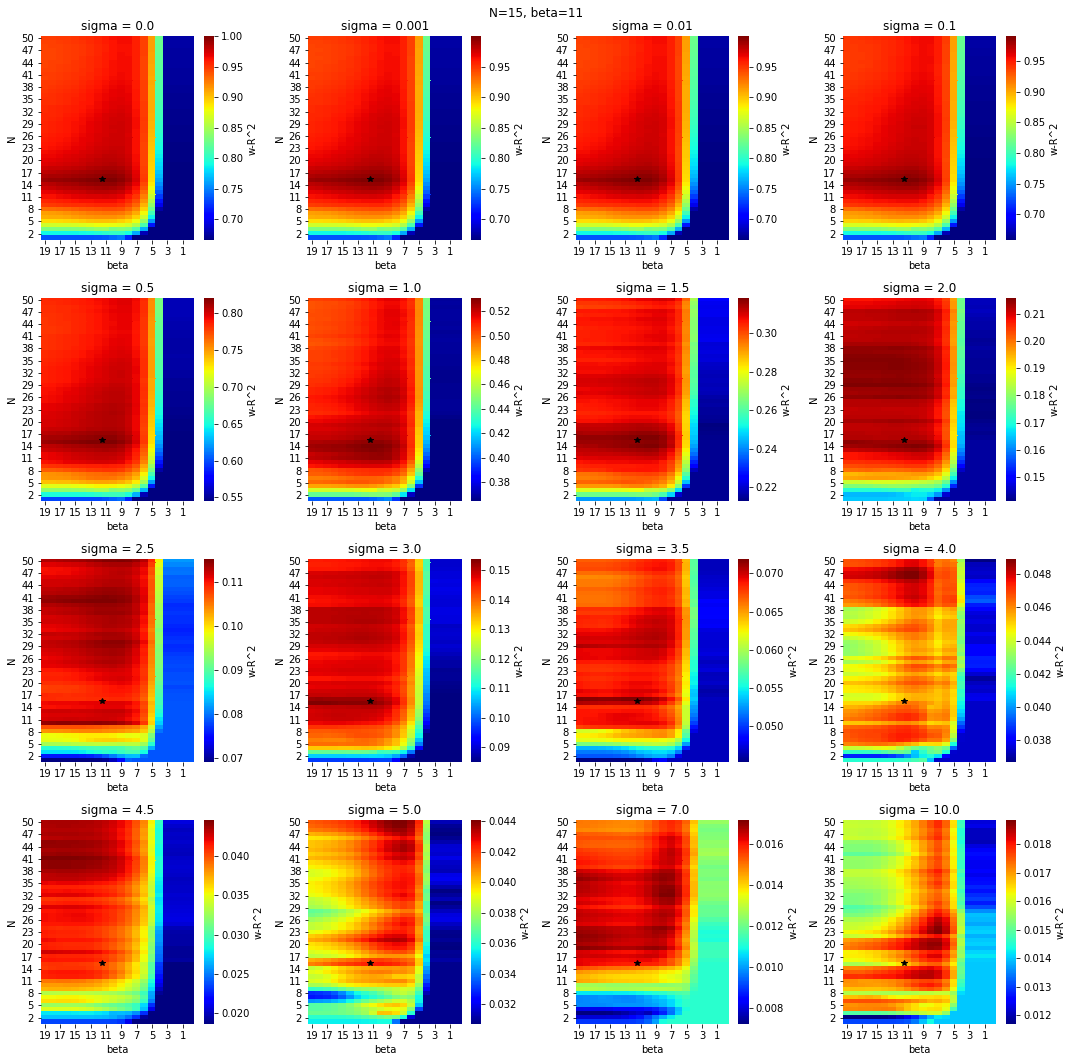

In [12]:
plot_noise_maps(d_noise, base_N, base_BETA)

 p_oddball of block is 0.1-0.5
N=15, beta=35.564803062231285


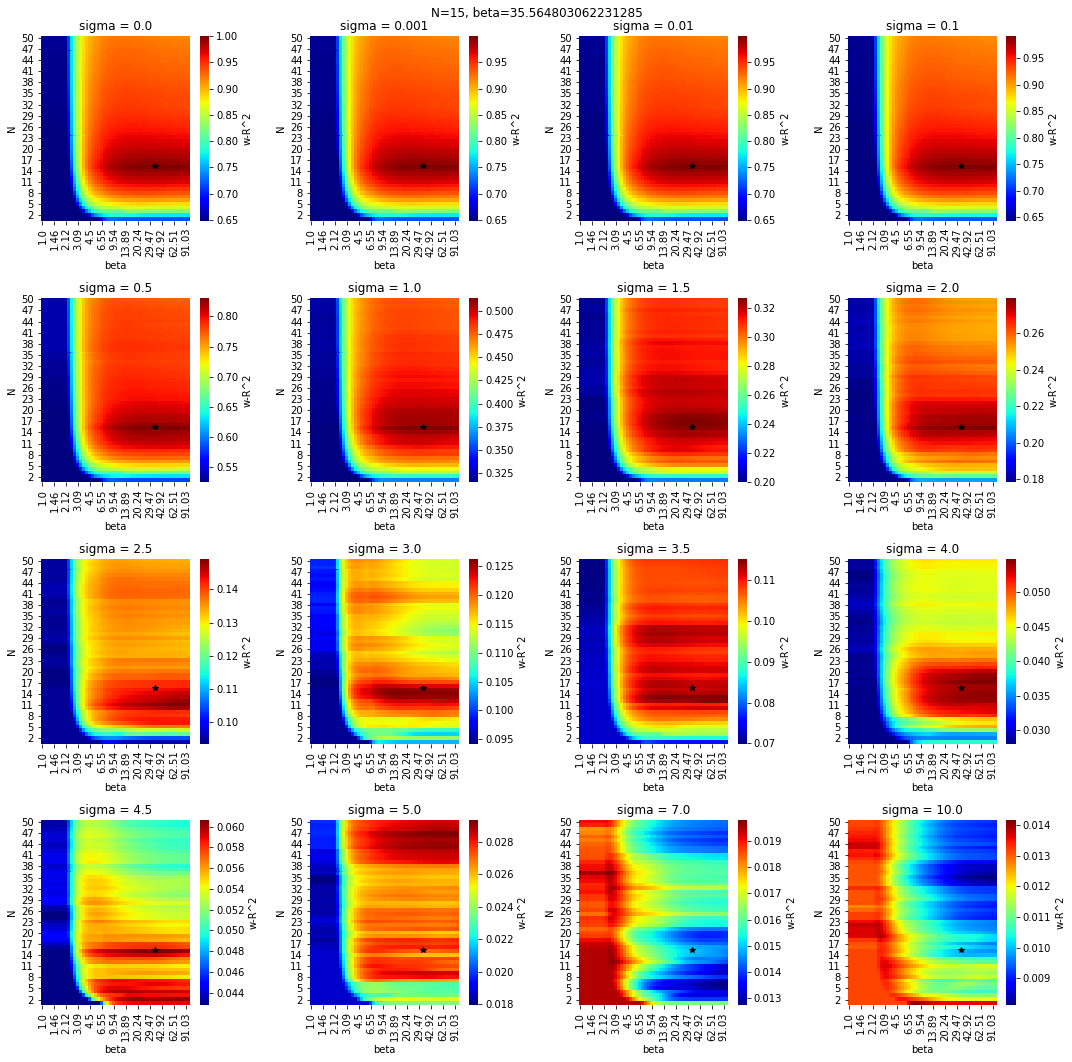

In [17]:
PATH = r"data/noise_simulation_analysis/"
plot_noise_maps(d_noise, base_N, base_BETA,
                filename=os.path.join(PATH,f"p_odd_1-5_N_{base_N}_beta_{int(base_BETA)}_scale.png"))

Median Value of R^2 as a function of noise level on simulation

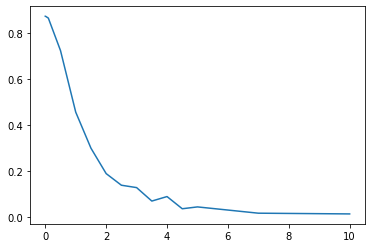

In [15]:
plt.plot(d_noise.keys(),[d_noise[sig].mean().mean() for sig in d_noise.keys()])

 p_oddball of block is 0.1-0.5
N=15, beta=35.564803062231285


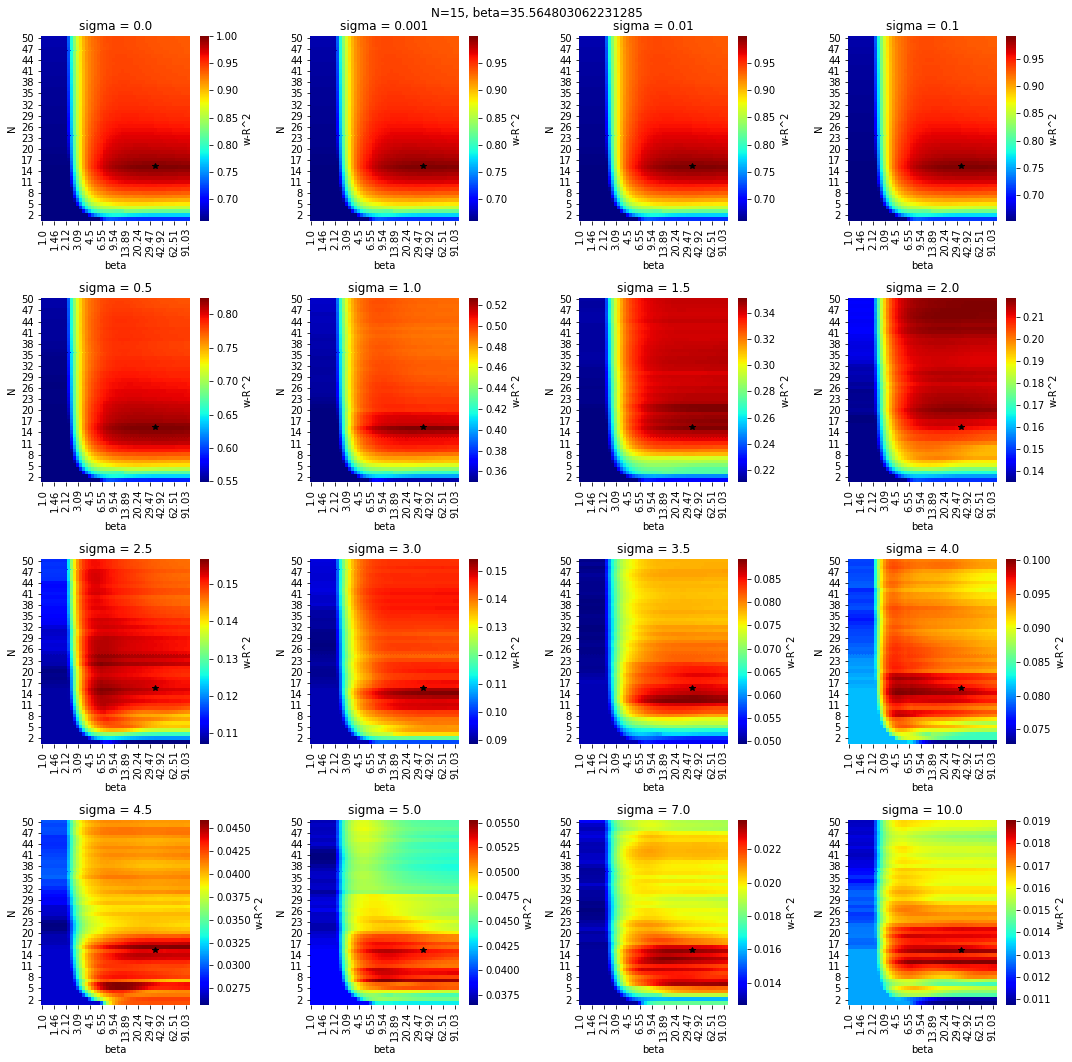

In [19]:
import seaborn as sns

def plot_noise_maps_unbound_color(d_noise, base_N, base_beta, binned=False, filename=None):
    fig = plt.figure(figsize=(15,15))
    fig.suptitle(f"N={base_N}, beta={base_BETA}")
    print(f" p_oddball of block is 0.1-0.5")
    print(f"N={base_N}, beta={base_beta}")
    for i, sig in enumerate(d_noise):
        if binned:
            num_bins = 20
            bins = np.linspace(0,1, num=num_bins+1)
            df_binned = d_noise[sig].apply(lambda col: pd.cut(col, bins=bins, labels=False, include_lowest=True))
            df_binned = df_binned.applymap(lambda x: bins[x+1])
            df_to_plot = df_binned
        else:
            df_to_plot = d_noise[sig]
        ax = fig.add_subplot(4,4,i+1)
        sns.heatmap(df_to_plot.rename(columns=lambda name: np.round(name,2)).iloc[::-1,::-1], 
                    cmap="jet",
                    cbar_kws={'label': f"w-R^2"}, ax=ax)
        plt.plot(np.argwhere(betas[::-1]==base_beta), np.argwhere(Ns[::-1]==base_N), '*k')
        plt.title(f"sigma = {sig}")

    plt.tight_layout()
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)

plot_noise_maps_unbound_color(d_noise, base_N, base_BETA)